In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LSTM EARLY STOPPING

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

In [ ]:
# Membaca data dari Google Drive
file_path = '/content/drive/MyDrive/DST/Balanced_Hasil_Preprocesing_CNN.csv'  # Ganti path dengan lokasi file Anda
df = pd.read_csv(file_path)

# Menampilkan informasi file
print("Informasi File:")
print(df.info())  # Tipe data dan jumlah nilai non-null

print("\nBeberapa Baris Data:")
print(df.head())

Informasi File:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    9600 non-null   object
 1   content  9600 non-null   object
 2   label    9600 non-null   object
dtypes: object(3)
memory usage: 225.1+ KB
None

Beberapa Baris Data:
                                               title  \
0  transmart full day sale lagi obral sepeda rp juta   
1  hitungan ekonom makan bergizi gratis beri rp t...   
2  akses perbankan agenbrilink situbondo sukses b...   
3  cerita sandiaga dampak perang timteng sektor w...   
4                               rupiah loyo rp pekan   

                                             content    label  
0  kabar gembira transmart full day sale lagi min...  ekonomi  
1  makan bergizi gratis prabowosubianto direktur ...  ekonomi  
2  chandra utama apresiasi kehadiran agenbrilink ...  ekonomi  
3  menparekraf sandiaga uno par

<ipython-input-4-5a1d196c7b84>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', palette='viridis')


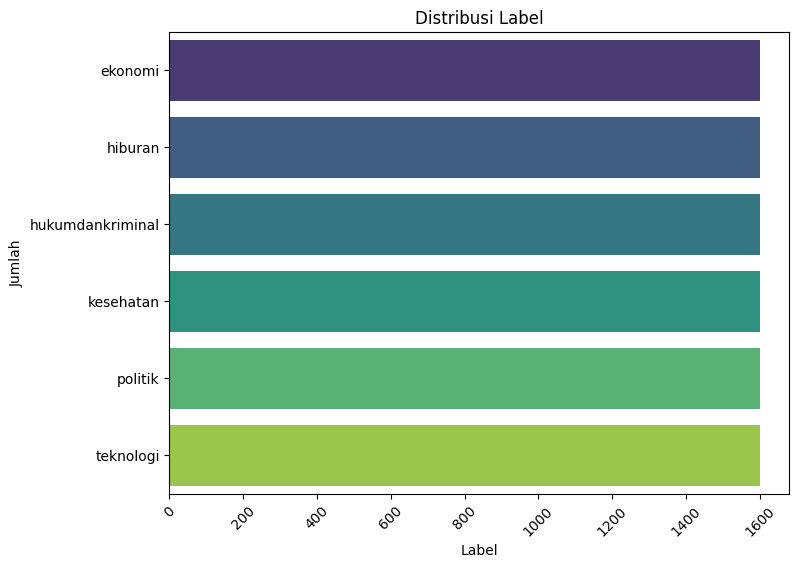

In [ ]:
# 2. Visualisasi distribusi label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='label', palette='viridis')
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Menyaring data kosong dan label unik
df = df.dropna(subset=['content', 'label'])

# Tokenisasi dan padding
max_words = 10000  # Jumlah kata maksimum yang digunakan
max_len = 300  # Panjang maksimum kalimat setelah padding

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])

X = tokenizer.texts_to_sequences(df['content'])
X = pad_sequences(X, maxlen=max_len)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [ ]:
# 3. Membagi data menjadi train dan test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 1. Meningkatkan dimensi embedding dan menambahkan stacked LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=256, input_length=max_len))  # Embedding
model.add(LSTM(128, return_sequences=True, dropout=0.3))  # LSTM pertama
model.add(LSTM(64, dropout=0.3))  # LSTM kedua
model.add(Dense(128, activation='relu'))  # Layer dense
model.add(Dropout(0.3))  # Dropout tambahan
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output sesuai jumlah label

# Kompilasi model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# 3. Melatih model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,  # Batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3152 - loss: 1.6087 - val_accuracy: 0.8203 - val_loss: 0.6210 - learning_rate: 5.0000e-04
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7937 - loss: 0.6395 - val_accuracy: 0.8536 - val_loss: 0.4951 - learning_rate: 5.0000e-04
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9012 - loss: 0.3652 - val_accuracy: 0.8547 - val_loss: 0.5035 - learning_rate: 5.0000e-04
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9377 - loss: 0.2737 - val_accuracy: 0.8651 - val_loss: 0.5124 - learning_rate: 5.0000e-04
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9505 - loss: 0.2042 - val_accuracy: 0.8693 - val_loss: 0.5028 - learning_rate: 2.5000e-04


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Validation Loss: 0.4942
Validation Accuracy: 0.8562
Evaluasi Model:
                  precision    recall  f1-score   support

         ekonomi       0.78      0.80      0.79       329
         hiburan       0.92      0.86      0.89       324
hukumdankriminal       0.89      0.79      0.84       326
       kesehatan       0.96      0.93      0.95       307
         politik       0.79      0.86      0.82       317
       teknologi       0.82      0.88      0.85       317

        accuracy                           0.86      1920
       macro avg       0.86      0.86      0.86      1920
    weighted avg       0.86      0.86      0.86      1920



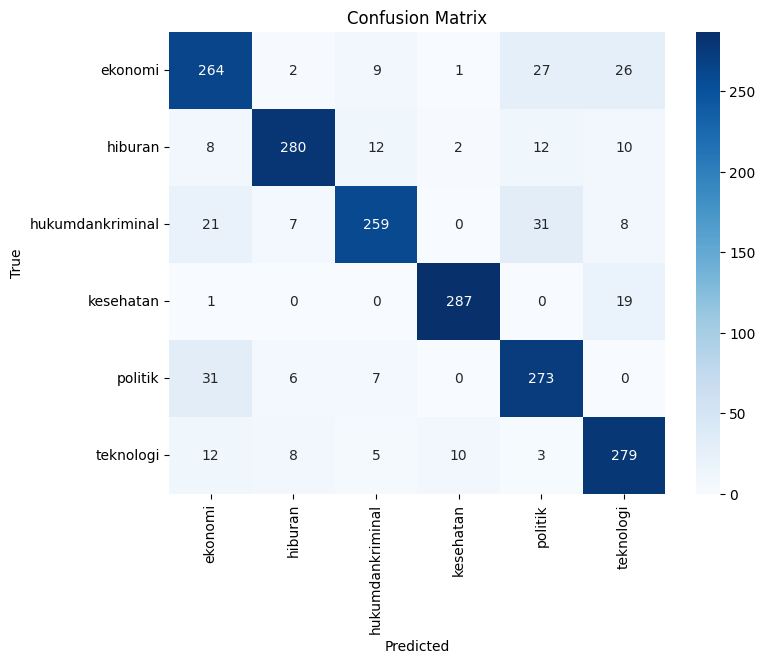

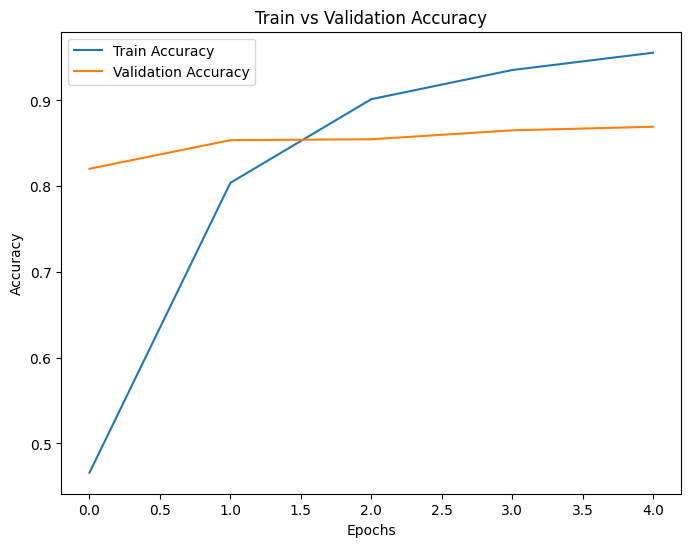

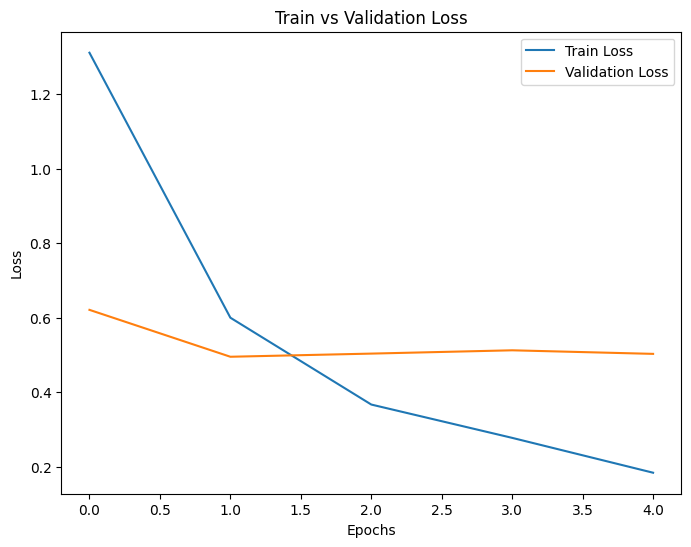

In [ ]:
# 7. Evaluasi Model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung loss dan accuracy pada dataset validasi
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Metrik evaluasi
print("Evaluasi Model:")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualisasi akurasi
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualisasi loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Menyimpan model ke Google Drive
model.save('/content/drive/MyDrive/DST/ujicoba1.h5')
print("Model telah disimpan ke Google Drive")

Model telah disimpan ke Google Drive


# Bi-LSTM EARLY STOPPING

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

In [ ]:
# Membaca data dari Google Drive
file_path = '/content/drive/MyDrive/DST/Balanced_Hasil_Preprocesing_CNN.csv'  # Ganti path dengan lokasi file Anda
df = pd.read_csv(file_path)

# Menampilkan informasi file
print("Informasi File:")
print(df.info())  # Tipe data dan jumlah nilai non-null

print("\nBeberapa Baris Data:")
print(df.head())

Informasi File:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    9600 non-null   object
 1   content  9600 non-null   object
 2   label    9600 non-null   object
dtypes: object(3)
memory usage: 225.1+ KB
None

Beberapa Baris Data:
                                               title  \
0  transmart full day sale lagi obral sepeda rp juta   
1  hitungan ekonom makan bergizi gratis beri rp t...   
2  akses perbankan agenbrilink situbondo sukses b...   
3  cerita sandiaga dampak perang timteng sektor w...   
4                               rupiah loyo rp pekan   

                                             content    label  
0  kabar gembira transmart full day sale lagi min...  ekonomi  
1  makan bergizi gratis prabowosubianto direktur ...  ekonomi  
2  chandra utama apresiasi kehadiran agenbrilink ...  ekonomi  
3  menparekraf sandiaga uno par

<ipython-input-3-5a1d196c7b84>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', palette='viridis')


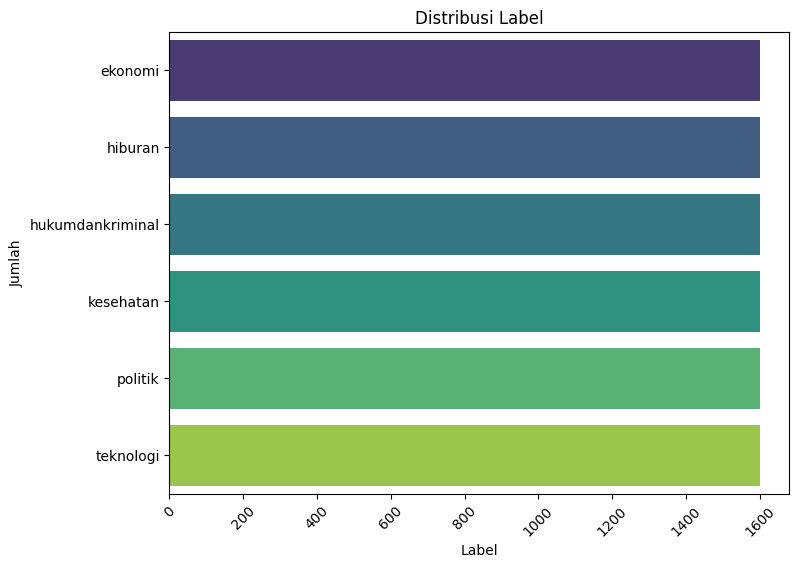

In [ ]:
# 2. Visualisasi distribusi label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='label', palette='viridis')
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Menyaring data kosong dan label unik
df = df.dropna(subset=['content', 'label'])

# Tokenisasi dan padding
max_words = 10000  # Jumlah kata maksimum yang digunakan
max_len = 300  # Panjang maksimum kalimat setelah padding

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])

X = tokenizer.texts_to_sequences(df['content'])
X = pad_sequences(X, maxlen=max_len)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [ ]:
# 3. Membagi data menjadi train dan test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. Membangun model Bi-Directional LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)))
model.add(Bidirectional(LSTM(64, dropout=0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# 4. Kompilasi model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])

# 5. Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# 6. Pelatihan model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.3543 - loss: 1.5498 - val_accuracy: 0.8250 - val_loss: 0.5593 - learning_rate: 5.0000e-04
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8655 - loss: 0.5114 - val_accuracy: 0.8589 - val_loss: 0.4911 - learning_rate: 5.0000e-04
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9132 - loss: 0.3398 - val_accuracy: 0.8630 - val_loss: 0.4901 - learning_rate: 5.0000e-04
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9139 - loss: 0.3248 - val_accuracy: 0.8578 - val_loss: 0.4917 - learning_rate: 5.0000e-04
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9513 - loss: 0.2101 - val_accuracy: 0.8813 - val_loss: 0.4724 - learning_rate: 5.0000e-04
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9573 - loss: 0.1920 - val_accuracy: 0.8703 - val_loss: 0.5178 - learning_rate: 5.0000e-04
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - ac

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Validation Loss: 0.4705
Validation Accuracy: 0.8760
Evaluasi Model:
                  precision    recall  f1-score   support

         ekonomi       0.85      0.81      0.83       329
         hiburan       0.90      0.87      0.89       324
hukumdankriminal       0.88      0.91      0.89       326
       kesehatan       0.97      0.96      0.96       307
         politik       0.83      0.86      0.85       317
       teknologi       0.85      0.87      0.86       317

        accuracy                           0.88      1920
       macro avg       0.88      0.88      0.88      1920
    weighted avg       0.88      0.88      0.88      1920



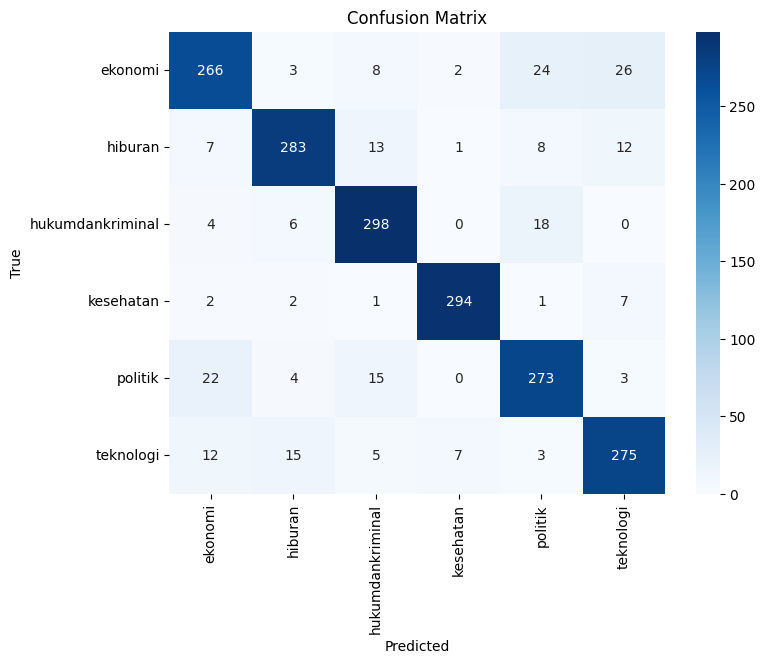

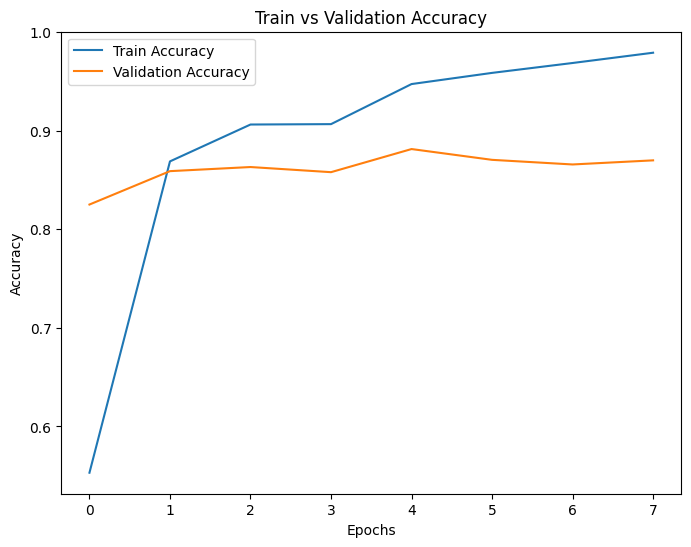

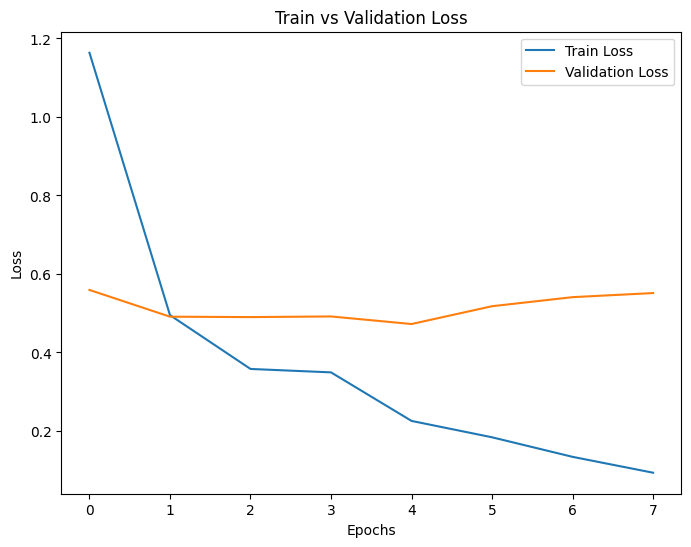

In [ ]:
# 7. Evaluasi Model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung loss dan accuracy pada dataset validasi
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Metrik evaluasi
print("Evaluasi Model:")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualisasi akurasi
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualisasi loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Menyimpan model ke Google Drive
model.save('/content/drive/MyDrive/DST/ujicoba2.h5')
print("Model telah disimpan ke Google Drive")

Model telah disimpan ke Google Drive


# LSTM FastText

In [ ]:
!pip install gensim


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors


In [ ]:
# Membaca data dari Google Drive
file_path = '/content/drive/MyDrive/DST/Balanced_Hasil_Preprocesing_CNN.csv'  # Ganti path dengan lokasi file Anda
df = pd.read_csv(file_path)

# Menampilkan informasi file
print("Informasi File:")
print(df.info())  # Tipe data dan jumlah nilai non-null

print("\nBeberapa Baris Data:")
print(df.head())

Informasi File:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    9600 non-null   object
 1   content  9600 non-null   object
 2   label    9600 non-null   object
dtypes: object(3)
memory usage: 225.1+ KB
None

Beberapa Baris Data:
                                               title  \
0  transmart full day sale lagi obral sepeda rp juta   
1  hitungan ekonom makan bergizi gratis beri rp t...   
2  akses perbankan agenbrilink situbondo sukses b...   
3  cerita sandiaga dampak perang timteng sektor w...   
4                               rupiah loyo rp pekan   

                                             content    label  
0  kabar gembira transmart full day sale lagi min...  ekonomi  
1  makan bergizi gratis prabowosubianto direktur ...  ekonomi  
2  chandra utama apresiasi kehadiran agenbrilink ...  ekonomi  
3  menparekraf sandiaga uno par

<ipython-input-5-5a1d196c7b84>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', palette='viridis')


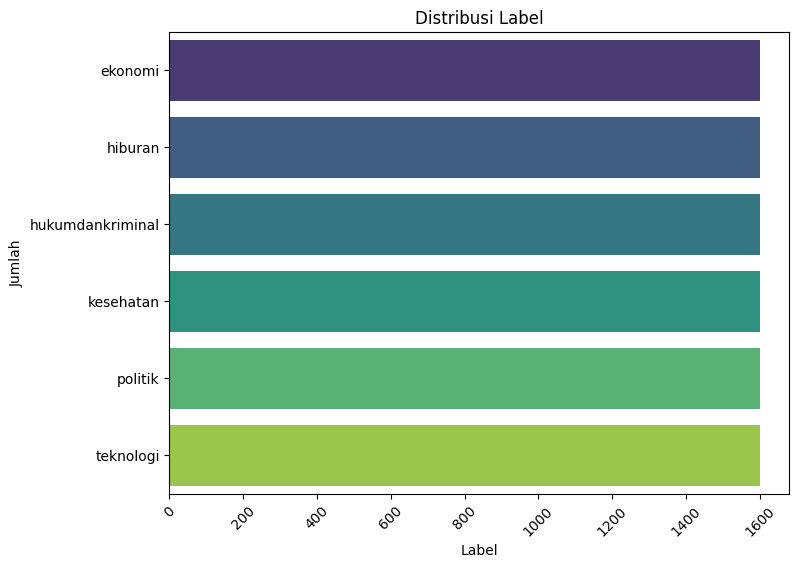

In [ ]:
# 2. Visualisasi distribusi label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='label', palette='viridis')
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Menyaring data kosong dan label unik
df = df.dropna(subset=['content', 'label'])

# Tokenisasi dan padding
max_words = 10000  # Jumlah kata maksimum yang digunakan
max_len = 300  # Panjang maksimum kalimat setelah padding
embedding_dim = 300  # Dimensi embedding FastText

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])

X = tokenizer.texts_to_sequences(df['content'])
X = pad_sequences(X, maxlen=max_len)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [ ]:
# 3. Membagi data menjadi train dan test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296188 sha256=ce76081d5aaa39fa89e256c06716867ab753c5373644d24b5d260e69711e31bf
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
#Memuat model FastText
print("Loading FastText model...")
fasttext_model = fasttext.load_model('/content/drive/MyDrive/DST/cc.id.300.bin')
print("FastText model loaded.")

# Membuat matriks embedding
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = fasttext_model.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(f"Matriks embedding selesai dengan ukuran: {embedding_matrix.shape}")


Loading FastText model...
FastText model loaded.
Matriks embedding selesai dengan ukuran: (10000, 300)


In [ ]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 4. Membangun model LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_len,
                    trainable=False))  # Embedding dengan FastText
model.add(LSTM(128, return_sequences=True, dropout=0.3))  # LSTM pertama
model.add(LSTM(64, dropout=0.3))  # LSTM kedua
model.add(Dense(128, activation='relu'))  # Dense layer
model.add(Dropout(0.3))  # Dropout tambahan
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output sesuai jumlah kelas

# Kompilasi model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Melatih model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,  # Batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.3440 - loss: 1.5826 - val_accuracy: 0.7063 - val_loss: 0.8400 - learning_rate: 5.0000e-04
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7225 - loss: 0.8303 - val_accuracy: 0.7625 - val_loss: 0.7251 - learning_rate: 5.0000e-04
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7821 - loss: 0.6838 - val_accuracy: 0.8125 - val_loss: 0.6170 - learning_rate: 5.0000e-04
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8251 - loss: 0.5931 - val_accuracy: 0.7844 - val_loss: 0.6470 - learning_rate: 5.0000e-04
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8107 - loss: 0.6208 - val_accuracy: 0.8177 - val_loss: 0.5627 - learning_rate: 5.0000e-04
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8115 - loss: 0.6285 - val_accuracy: 0.8156 - val_loss: 0.5943 - learning_rate: 5.0000e-04
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.82

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Validation Loss: 0.4798
Validation Accuracy: 0.8531
Evaluasi Model:
                  precision    recall  f1-score   support

         ekonomi       0.83      0.80      0.81       329
         hiburan       0.93      0.80      0.86       324
hukumdankriminal       0.81      0.86      0.83       326
       kesehatan       0.92      0.97      0.94       307
         politik       0.74      0.89      0.81       317
       teknologi       0.90      0.78      0.84       317

        accuracy                           0.85      1920
       macro avg       0.85      0.85      0.85      1920
    weighted avg       0.85      0.85      0.85      1920



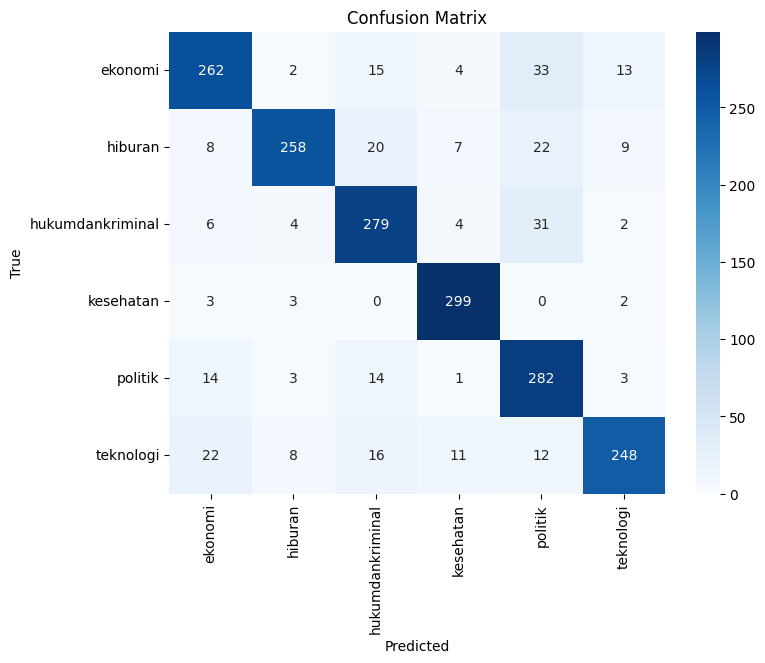

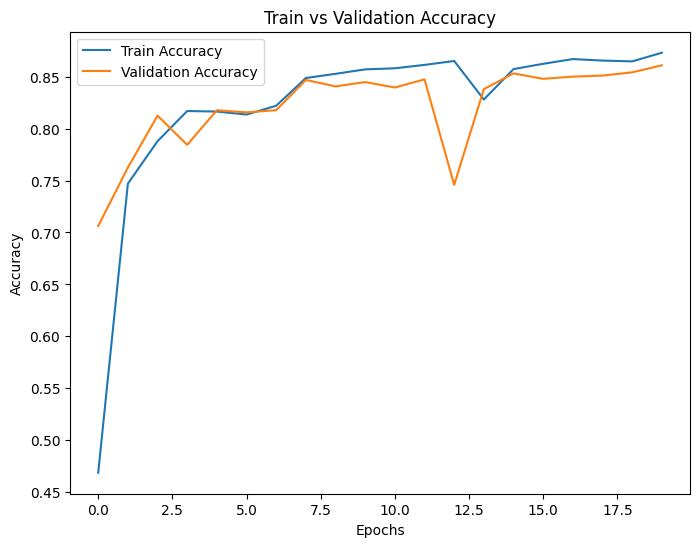

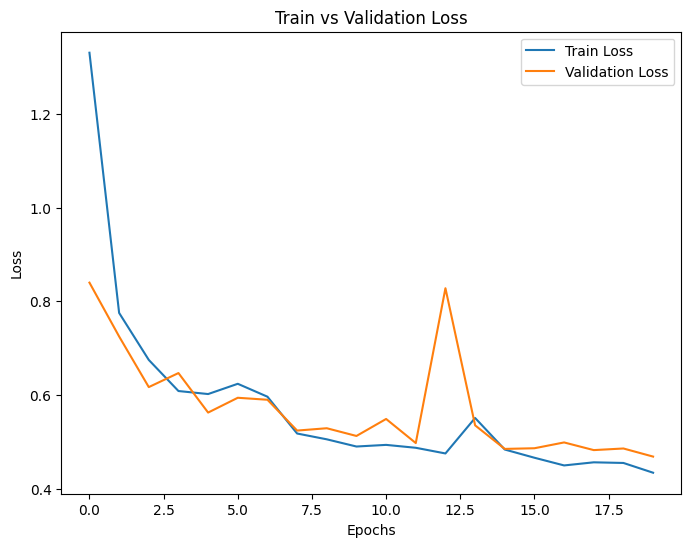

In [ ]:
# 7. Evaluasi Model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung loss dan accuracy pada dataset validasi
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Metrik evaluasi
print("Evaluasi Model:")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualisasi akurasi
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualisasi loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# 8. Prediksi dengan Input Pengguna
def predict_news_topic(news_text):
    # Tokenisasi dan padding input berita
    seq = tokenizer.texts_to_sequences([news_text])
    padded_seq = pad_sequences(seq, maxlen=max_len)

    # Melakukan prediksi
    prediction = model.predict(padded_seq)
    predicted_label = label_encoder.classes_[np.argmax(prediction)]
    confidence = np.max(prediction)

    return predicted_label, confidence

# Tes dengan input berita
news_input = "Contoh dampak teknologi terhadap industri."
predicted_label, confidence = predict_news_topic(news_input)
print(f"Prediksi Topik: {predicted_label} dengan Confidence Score: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediksi Topik: teknologi dengan Confidence Score: 0.49


In [ ]:
# Menyimpan model ke Google Drive
model.save('/content/drive/MyDrive/DST/fasttextlstm.h5')
print("Model telah disimpan ke Google Drive")

Model telah disimpan ke Google Drive


# Bi-LSTM FastText

In [ ]:
!pip install gensim


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors


In [ ]:
# Membaca data dari Google Drive
file_path = '/content/drive/MyDrive/DST/Balanced_Hasil_Preprocesing_CNN.csv'  # Ganti path dengan lokasi file Anda
df = pd.read_csv(file_path)

# Menampilkan informasi file
print("Informasi File:")
print(df.info())  # Tipe data dan jumlah nilai non-null

print("\nBeberapa Baris Data:")
print(df.head())

Informasi File:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    9600 non-null   object
 1   content  9600 non-null   object
 2   label    9600 non-null   object
dtypes: object(3)
memory usage: 225.1+ KB
None

Beberapa Baris Data:
                                               title  \
0  transmart full day sale lagi obral sepeda rp juta   
1  hitungan ekonom makan bergizi gratis beri rp t...   
2  akses perbankan agenbrilink situbondo sukses b...   
3  cerita sandiaga dampak perang timteng sektor w...   
4                               rupiah loyo rp pekan   

                                             content    label  
0  kabar gembira transmart full day sale lagi min...  ekonomi  
1  makan bergizi gratis prabowosubianto direktur ...  ekonomi  
2  chandra utama apresiasi kehadiran agenbrilink ...  ekonomi  
3  menparekraf sandiaga uno par

<ipython-input-24-5a1d196c7b84>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', palette='viridis')


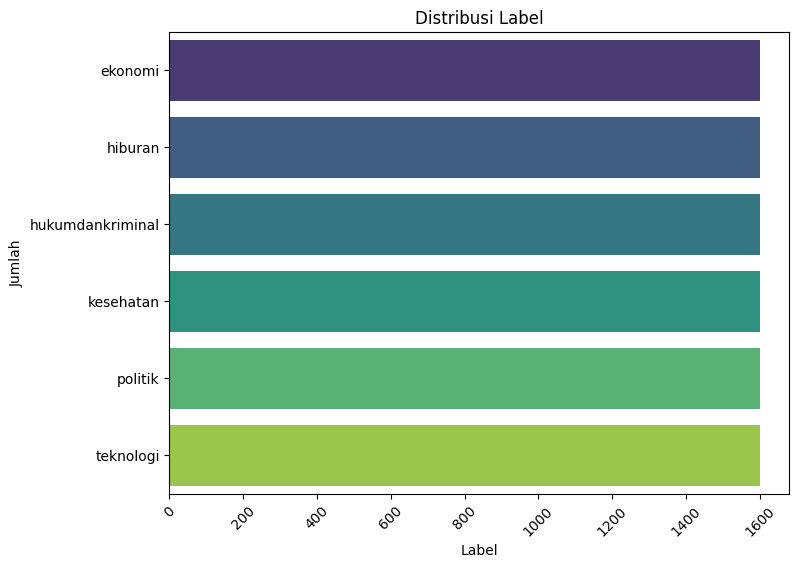

In [ ]:
# 2. Visualisasi distribusi label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='label', palette='viridis')
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Menyaring data kosong dan label unik
df = df.dropna(subset=['content', 'label'])

# Tokenisasi dan padding
max_words = 10000  # Jumlah kata maksimum yang digunakan
max_len = 300  # Panjang maksimum kalimat setelah padding
embedding_dim = 300  # Dimensi embedding FastText

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])

X = tokenizer.texts_to_sequences(df['content'])
X = pad_sequences(X, maxlen=max_len)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [ ]:
# 3. Membagi data menjadi train dan test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296188 sha256=ce76081d5aaa39fa89e256c06716867ab753c5373644d24b5d260e69711e31bf
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
#Memuat model FastText
print("Loading FastText model...")
fasttext_model = fasttext.load_model('/content/drive/MyDrive/DST/cc.id.300.bin')
print("FastText model loaded.")

# Membuat matriks embedding
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = fasttext_model.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(f"Matriks embedding selesai dengan ukuran: {embedding_matrix.shape}")


Loading FastText model...
FastText model loaded.
Matriks embedding selesai dengan ukuran: (10000, 300)


In [ ]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 4. Membangun model LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_len,
                    trainable=False))  # Embedding dengan FastText
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)))  # Bi-LSTM pertama
model.add(Bidirectional(LSTM(64, dropout=0.3))) # Bi-LSTM kedua
model.add(Dense(128, activation='relu'))  # Dense layer
model.add(Dropout(0.3))  # Dropout tambahan
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output sesuai jumlah kelas

# Kompilasi model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Melatih model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,  # Batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.3086 - loss: 1.6804 - val_accuracy: 0.3438 - val_loss: 1.5202 - learning_rate: 5.0000e-04
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4642 - loss: 1.3264 - val_accuracy: 0.6953 - val_loss: 0.8786 - learning_rate: 5.0000e-04
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7487 - loss: 0.7789 - val_accuracy: 0.7646 - val_loss: 0.7258 - learning_rate: 5.0000e-04
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7766 - loss: 0.6988 - val_accuracy: 0.7505 - val_loss: 0.7699 - learning_rate: 5.0000e-04
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7746 - loss: 0.7014 - val_accuracy: 0.7729 - val_loss: 0.6914 - learning_rate: 5.0000e-04
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7958 - loss: 0.6486 - val_accuracy: 0.7922 - val_loss: 0.6466 - learning_rate: 5.0000e-04
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Validation Loss: 0.4206
Validation Accuracy: 0.8693
Evaluasi Model:
                  precision    recall  f1-score   support

         ekonomi       0.80      0.80      0.80       329
         hiburan       0.91      0.82      0.86       324
hukumdankriminal       0.84      0.86      0.85       326
       kesehatan       0.94      0.97      0.95       307
         politik       0.78      0.85      0.81       317
       teknologi       0.87      0.82      0.84       317

        accuracy                           0.85      1920
       macro avg       0.86      0.85      0.85      1920
    weighted avg       0.86      0.85      0.85      1920



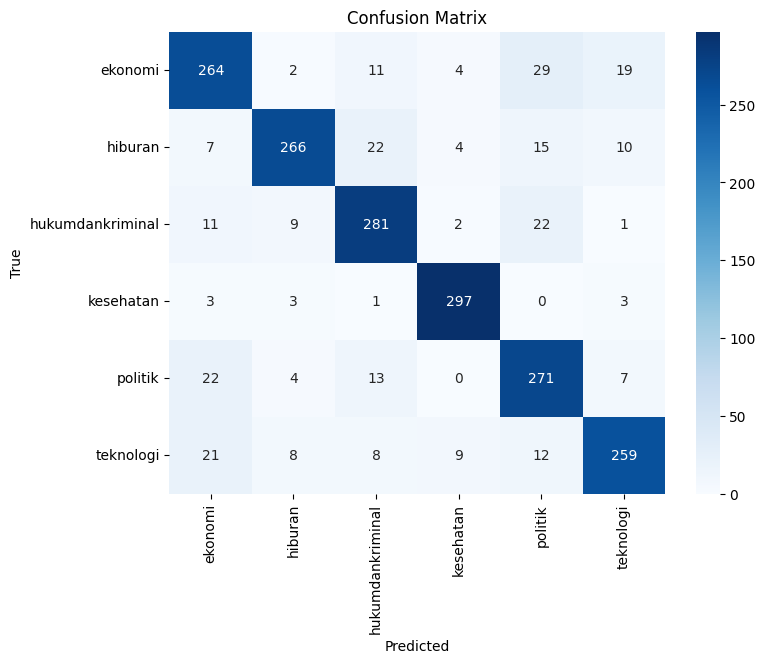

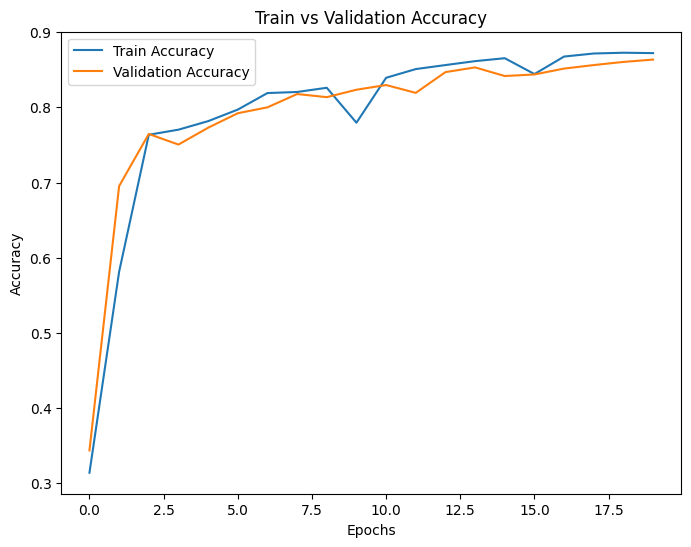

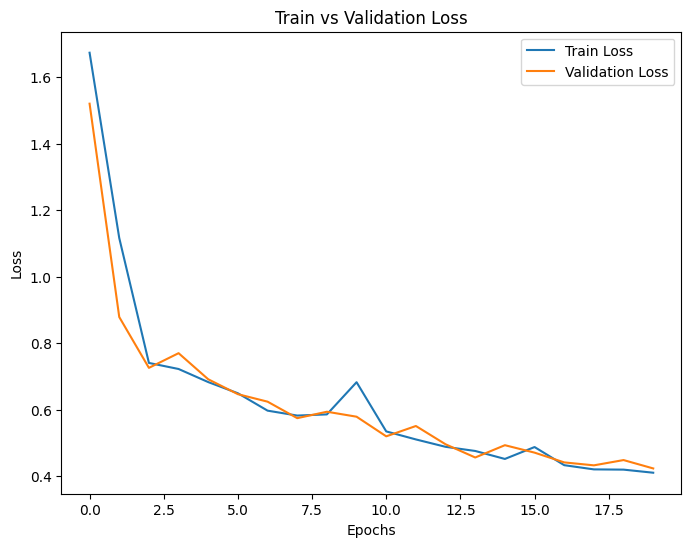

In [ ]:
# 7. Evaluasi Model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung loss dan accuracy pada dataset validasi
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Metrik evaluasi
print("Evaluasi Model:")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualisasi akurasi
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualisasi loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# 8. Prediksi dengan Input Pengguna
def predict_news_topic(news_text):
    # Tokenisasi dan padding input berita
    seq = tokenizer.texts_to_sequences([news_text])
    padded_seq = pad_sequences(seq, maxlen=max_len)

    # Melakukan prediksi
    prediction = model.predict(padded_seq)
    predicted_label = label_encoder.classes_[np.argmax(prediction)]
    confidence = np.max(prediction)

    return predicted_label, confidence

# Tes dengan input berita
news_input = "Contoh dampak teknologi terhadap industri."
predicted_label, confidence = predict_news_topic(news_input)
print(f"Prediksi Topik: {predicted_label} dengan Confidence Score: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediksi Topik: teknologi dengan Confidence Score: 0.49


In [ ]:
# Menyimpan model ke Google Drive
model.save('/content/drive/MyDrive/DST/fasttextbilstm.h5')
print("Model telah disimpan ke Google Drive")

Model telah disimpan ke Google Drive
